In [498]:
import pandas as pd

/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [499]:
#loading the data
data = pd.read_csv('Corpus.csv', error_bad_lines=False);

/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [500]:
#number of rows and column
data.shape


/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(470, 1)

In [501]:
data.head

/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<bound method NDFrame.head of                                                                                                  content
0    People are not only searching for new solutions to existing problems. They areso searching for n...
1    The outcome of design must be meaningful to others. The product is used to communicate this mean...
2    Product meanings could be divided into functional and symbolic product meanings, whereas other r...
3    In order to differentiate between different types of innovation, Norman and Verganti define an i...
4    Apart from the identification of the enablers and barriers, the case study (Swedish furniture co...
..                                                                                                   ...
465  Looking at level, companies can the\r\napplied methodologies in order to gain insights about mar...
466  Support Vector Regressiongorithm will serve to prompt or warn contractors before the commencemen...
467  Data are the first s

In [502]:
#Keeping English, cleaning data
from langdetect import detect
from tqdm import tqdm_notebook
tqdm_notebook().pandas()
data['lang'] = data.content.progress_map(detect)
data.lang.value_counts()



/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-502-2eb285daf458>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

en    470
Name: lang, dtype: int64

In [503]:
# Import the wordcloud library
# word cloud before implementing stop words 
import matplotlib.pyplot as plt

#from wordcloud import WordCloud
# Join the different processed titles together.
#long_string = ','.join(list(data['content'].values))
# Create a WordCloud object
#wordcloud = WordCloud(background_color="black", max_words=5000, contour_width=10, contour_color='steelblue')
# Generate a word cloud
#wordcloud.generate(long_string)
# Visualize the word cloud
##wordcloud.to_image()
#wordcloud.to_file('N.png')

#changes





/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [504]:
#Tokenization
#Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
data['sentences'] = data.content.progress_map(sent_tokenize)
#data['sentences'].head(1).tolist()[0][:3] # Print the first row

/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/faithachile/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  0%|          | 0/470 [00:00<?, ?it/s]

In [505]:

#tokenization 
from nltk.tokenize import word_tokenize
data['tokens_sentences'] = data['sentences'].progress_map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])
#print(data['tokens_sentences'].head(1).tolist()[0][:3])

/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/470 [00:00<?, ?it/s]

In [506]:
#Lemmatization - verbs in past and future tenses are changed into present.
#Lemmatizing with POS tagging¶
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
data['POS_tokens'] = data['tokens_sentences'].progress_map(lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences])
#print(data['POS_tokens'].head(1).tolist()[0][:3])


/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/faithachile/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


  0%|          | 0/470 [00:00<?, ?it/s]

In [507]:
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [508]:

# Lemmatizing each word with its POS tag, in each sentence
data['tokens_sentences_lemmatized'] = data['POS_tokens'].progress_map(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/470 [00:00<?, ?it/s]

In [509]:
data['tokens_sentences_lemmatized'].head(1).tolist()[0][:3]

/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['People',
  'be',
  'not',
  'only',
  'search',
  'for',
  'new',
  'solution',
  'to',
  'exist',
  'problem',
  '.'],
 ['They',
  'areso',
  'search',
  'for',
  'new',
  'meaning',
  'because',
  'their',
  'life',
  'keep',
  'change',
  'and',
  'because',
  'they',
  'be',
  'delight',
  'by',
  'the',
  'discovery',
  'of',
  'new',
  'direction',
  '.']]

In [510]:
#Regrouping tokens and removing stop words¶
#nlk is a package for building Python programs to work with human language data
from nltk.corpus import stopwords
#stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']


with open('stopwords.txt', 'r') as file:dataExtendedStopwords = file.read().replace('\n', '')
stop_words = stopwords.words('english')
stop_words.extend(dataExtendedStopwords)
#my_stopwords = stop_words
#my_stopwords = stop_words + stopwords_other
#my_stopwords = stopwords_other
#print(my_stopwords)
from itertools import chain # to flatten list of sentences of tokens into list of tokens
data['tokens'] = data['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
data['tokens'] = data['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in stop_words and len(token)>1])
print(data['tokens'])



/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      [people, search, new, solution, exist, problem, areso, search, new, meaning, life, keep, change,...
1                          [outcome, design, must, meaningful, others, product, use, communicate, meaning]
2      [product, meaning, could, divide, functional, symbolic, product, meaning, whereas, researcher, d...
3      [order, differentiate, different, type, innovation, norman, verganti, define, incremental, innov...
4      [apart, identification, enablers, barrier, case, study, swedish, furniture, company, provide, in...
                                                      ...                                                 
465    [looking, level, company, applied, methodology, order, gain, insight, market, sentiment, prevail...
466    [support, vector, regressiongorithm, serve, prompt, warn, contractor, commencement, execution, p...
467    [data, first, step, advance, understanding, real, estate, enable, effective, ml, without, source...
468    [despite, benefit, machine, le

In [511]:
#LDA preparation
#Prepare bi-grams and tri-grams
from gensim.models import Phrases
tokens = data['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])


/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [512]:
#Prepare objects for LDA gensim implementation¶
from gensim import corpora
dictionary_LDA = corpora.Dictionary(tokens)
#dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(token) for token in tokens]
print(corpus[:2])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 1), (11, 1), (12, 2), (13, 1)], [(8, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)]]


/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [513]:
#Running LDA
from gensim import models
import numpy as np
np.random.seed(123456)
num_topics = 10
lda_model = models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, chunksize=450, \
                                  id2word=dictionary_LDA, random_state=500, \
                                  passes=10, alpha='auto', per_word_topics=True, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [514]:
#Viewing the topics
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
  

0: 0.030*"business_model" + 0.025*"teece" + 0.024*"need" + 0.023*"model" + 0.023*"revenue" + 0.020*"business" + 0.018*"capture_value" + 0.018*"change" + 0.018*"determine" + 0.017*"customer_segment"
1: 0.052*"size" + 0.017*"know" + 0.015*"transaction" + 0.015*"shopping" + 0.015*"way" + 0.015*"provide_consumer" + 0.013*"value" + 0.012*"one" + 0.012*"establish" + 0.012*"company"
2: 0.044*"use" + 0.033*"contractor" + 0.026*"measurement" + 0.025*"system" + 0.024*"company" + 0.023*"consumer" + 0.023*"base" + 0.020*"help" + 0.018*"experience" + 0.016*"firm"
3: 0.058*"may" + 0.042*"information" + 0.037*"customer" + 0.035*"firm" + 0.033*"various" + 0.029*"get" + 0.027*"investor" + 0.025*"include" + 0.025*"might" + 0.024*"advance"
4: 0.047*"innovation" + 0.031*"machine_learning" + 0.031*"sentiment" + 0.031*"price" + 0.029*"value" + 0.023*"new_technology" + 0.023*"individual" + 0.023*"level" + 0.022*"process" + 0.021*"home"
5: 0.040*"data" + 0.036*"market" + 0.030*"body" + 0.027*"company" + 0.022

/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [515]:
top_words_per_topic = []

for t in range(lda_model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 10)])

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("10Topics.csv")

/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [516]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# importing os module 
#OS module in Python provides functions for interacting with the operating system
import os 
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary_LDA)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, str(num_topics) +'.html')
LDAvis_prepared




/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.096335 -0.026221       1        1  18.007610
5     -0.138513 -0.087418       2        1  11.025159
0      0.243265  0.089971       3        1  10.979365
9      0.061212 -0.097989       4        1  10.399244
2     -0.105218 -0.124888       5        1   9.414342
8      0.135556 -0.271218       6        1   9.409870
6      0.124619  0.266522       7        1   9.128306
4     -0.041245  0.054576       8        1   8.103224
7     -0.271704  0.073451       9        1   7.705435
3     -0.104307  0.123213      10        1   5.827444, topic_info=            Term        Freq       Total Category  logprob  loglift
2490        size  133.000000  133.000000  Default  30.0000  30.0000
1191    activity   89.000000   89.000000  Default  29.0000  29.0000
20       product  143.000000  143.000000  Default  28.0000  28.0000
1124      profit   69.000000   69.000000  Default  27.0000  27.0000
57    innovation  114.000000  114.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
366      service    6.416770   31.818504  Topic10  -4.8565   1.2415
1106  technology    7.729490   89.873840  Topic10  -4.6704   0.3892
532      economy    5.134574   18.666150  Topic10  -5.0794   1.5519
72        enable    5.358653   39.106193  Topic10  -5.0367   0.8550
48         value    5.677760  154.958948  Topic10  -4.9789  -0.4640

[528 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
369       1  0.624482       able
369       9  0.361542       able
795       3  0.039039  according
795       6  0.936929  according
2426      2  1.006446   accurate
...     ...       ...        ...
794       5  1.011570      world
2582      1  0.072338  worldwide
2582      7  0.868056  worldwide
148       7  0.638119      yield
2250      5  0.997589       zoom

[805 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 1, 10, 3, 9, 7, 5, 8, 4])

In [517]:
#What is the Dominant topic and its percentage contribution in each document
#In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. 
#The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.
#This way, you will know which document belongs predominantly to which topic.




def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=tokens)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.8139,"product, avoid, offer, provide, set, expectation, extend, managerial, explore, appropriate","[people, search, new, solution, exist, problem, areso, search, new, meaning, life, keep, change,..."
1,1,9.0,0.5932,"product, avoid, offer, provide, set, expectation, extend, managerial, explore, appropriate","[outcome, design, must, meaningful, others, product, use, communicate, meaning]"
2,2,7.0,0.8654,"technology, store, location, consumer, evaluate, experience, online, great, easy, advantage","[product_meaning, could, divide, functional, symbolic, product_meaning, whereas, researcher, dis..."
3,3,1.0,0.6051,"size, know, transaction, shopping, way, provide_consumer, value, one, establish, company","[order, differentiate, different_type, innovation, norman, verganti, define, incremental_innovat..."
4,4,1.0,0.4618,"size, know, transaction, shopping, way, provide_consumer, value, one, establish, company","[apart, identification_enablers, barrier, case_study, swedish, furniture, company, provide, insi..."
5,5,1.0,0.3351,"size, know, transaction, shopping, way, provide_consumer, value, one, establish, company","[identification_enablers, barrier, design, driven_innovation, connection, interaction, relevance..."
6,6,0.0,0.5970,"business_model, teece, need, model, revenue, business, capture_value, change, determine, custome...","[limitation, material, choice, lack, flexibility, supplier, influence, overall, communication, n..."
7,7,6.0,0.4260,"activity, value, innovation, research, include, profitability, interpretation, variable, firm, s...","[social, learning, operate, two, distinct, sometimes, oppose, channel, one, hand, help, consumer..."
8,8,3.0,0.5048,"may, information, customer, firm, various, get, investor, include, might, advance","[internet, culture, lurker, special, group, website, user, regularly, login, online_community, s..."
9,9,9.0,0.6456,"product, avoid, offer, provide, set, expectation, extend, managerial, explore, appropriate","[nature, online_community, affect, user, impression, community, therefore, influence, user, will..."


In [518]:
#The most representative sentence for each topic
# Display setting to show more characters in column

pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9214,"business_model, teece, need, model, revenue, business, capture_value, change, determine, custome...","[content_structure, governance, highly, interdependent, need, line, value_creation, capture, goa..."
1,1.0,0.9557,"size, know, transaction, shopping, way, provide_consumer, value, one, establish, company","[new, company_commit, scale, need_operate, across_border, innovate_relentlessly, profitably_adop..."
2,2.0,0.9300,"use, contractor, measurement, system, company, consumer, base, help, experience, firm","[value_creation, achieve, manufacturing, industrial, agricultural, raw_material, internal, custo..."
3,3.0,0.9308,"may, information, customer, firm, various, get, investor, include, might, advance","[mechanisms, put_place, facilitate, consultation, among_various, digital_health, stakeholder, in..."
4,4.0,0.9616,"innovation, machine_learning, sentiment, price, value, new_technology, individual, level, proces...","[tweaking, application, value, mean, willingness, ability_make, small, change, venture, innovati..."
5,5.0,0.9693,"data, market, body, company, information, well, new, necessary, insight, characteristic","[enabling, efficient, infrastructure, share, different, network, user, open, ecosystem, new, pla..."
6,6.0,0.9493,"activity, value, innovation, research, include, profitability, interpretation, variable, firm, s...","[widespread, smartphones, medical, workplace, software_application, ability_translate, language,..."
7,7.0,0.8654,"technology, store, location, consumer, evaluate, experience, online, great, easy, advantage","[product_meaning, could, divide, functional, symbolic, product_meaning, whereas, researcher, dis..."
8,8.0,0.9521,"profit, project, literature, towards, according, discuss, hire, sustainability, choice, achieve","[attracting, new_member, raise, challenge, recruit_new, member, ii, select, right, member, iii, ..."
9,9.0,0.9676,"product, avoid, offer, provide, set, expectation, extend, managerial, explore, appropriate","[need_rethink, optimal_mix, product_service, business, identify_since, digital_part, hybrid_solu..."


/Users/faithachile/Documents/Anaconda/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-519-cfab281307bd>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-519-cfab281307bd>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-519-cfab281307bd>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalign

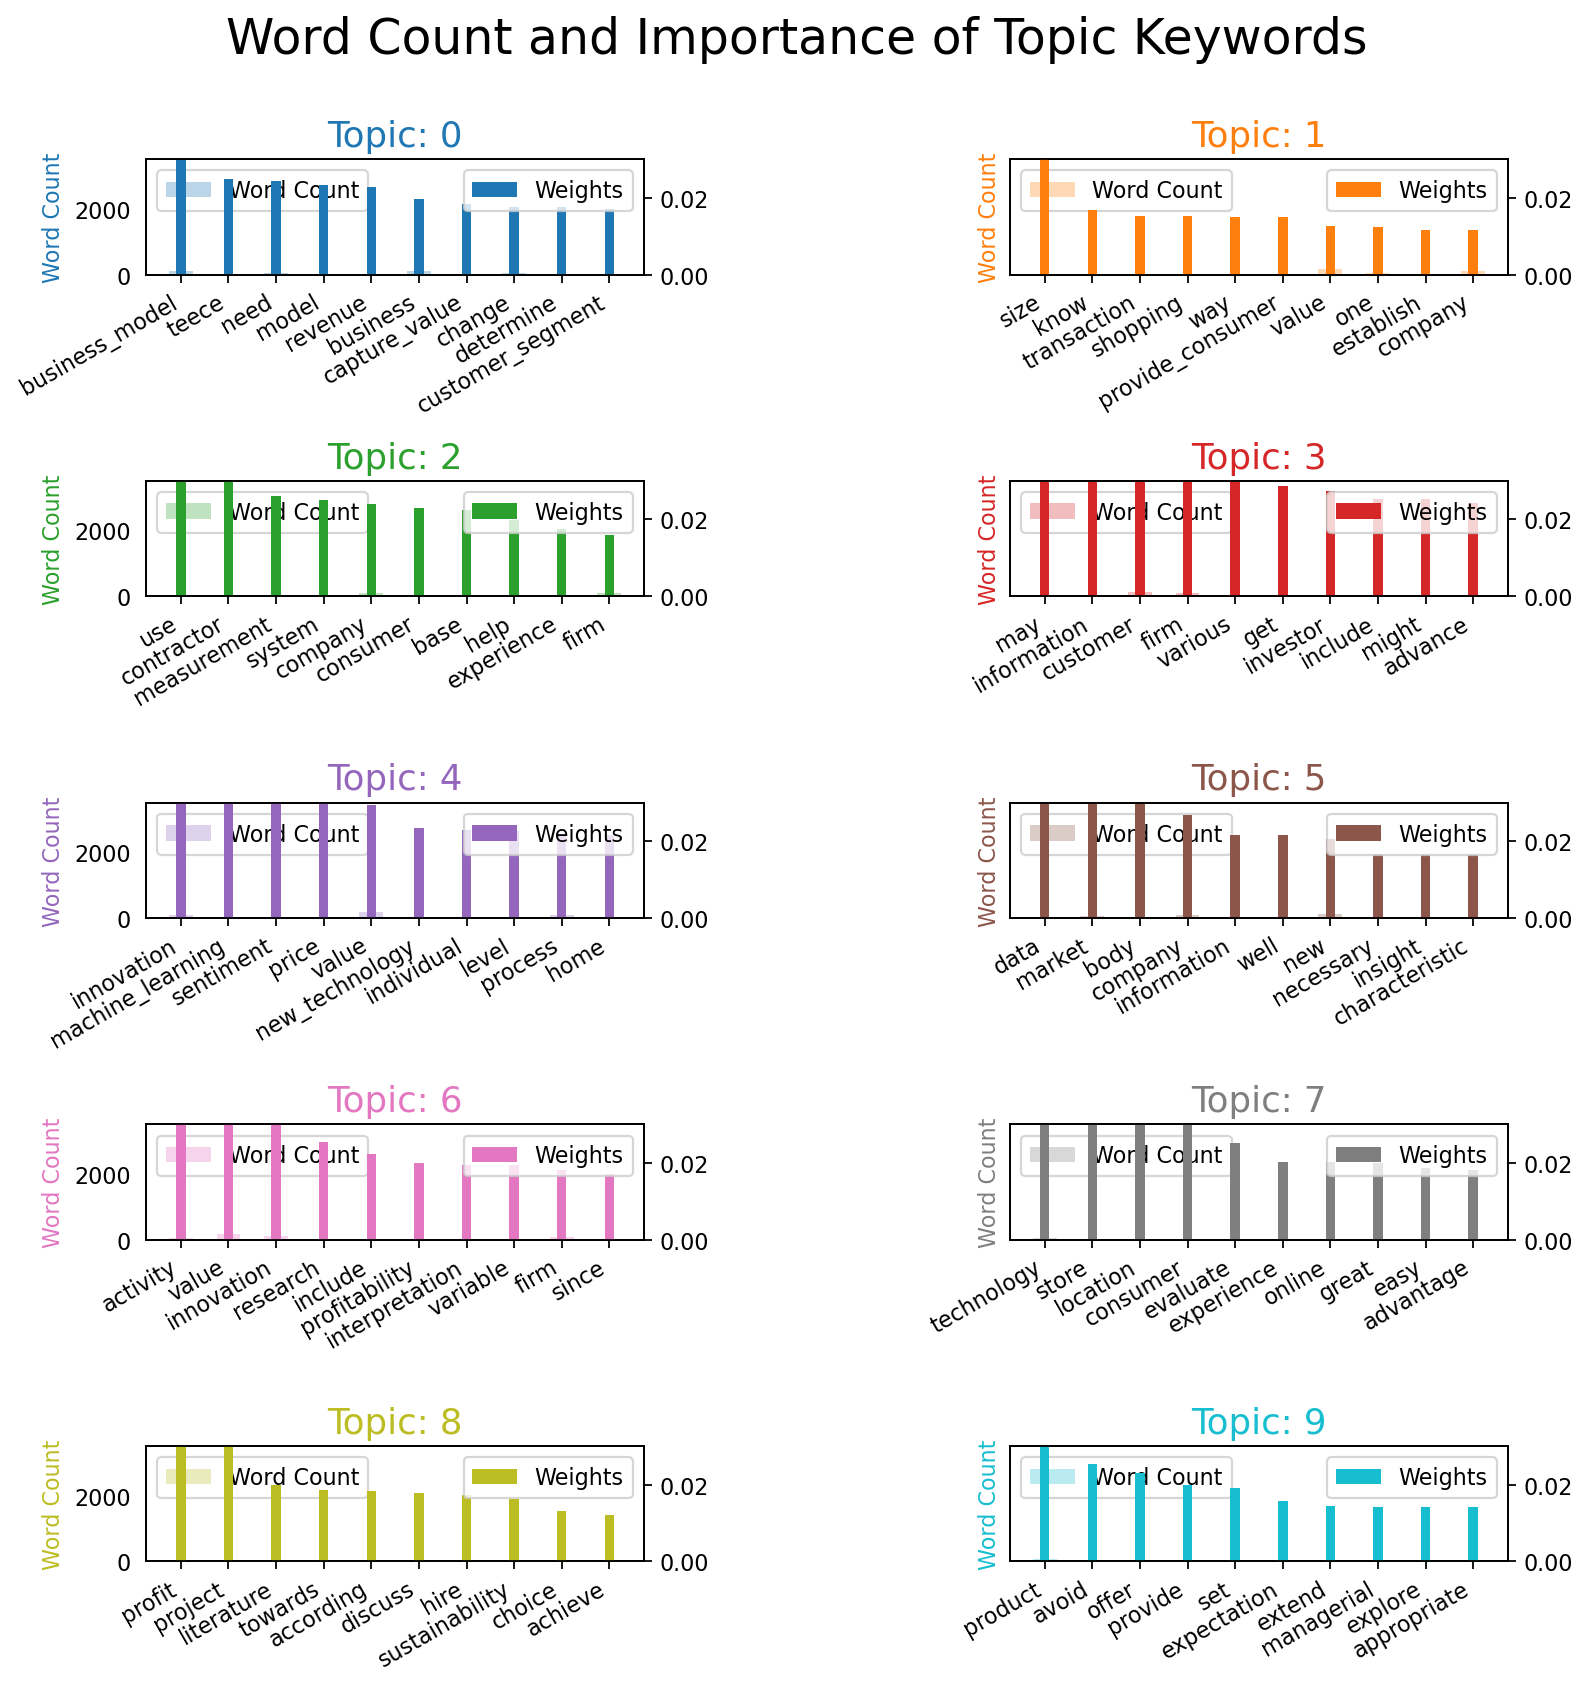

In [519]:
#Let’s plot the word counts and the weights of each keyword in the same chart.
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in tokens for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
import matplotlib.colors as mcolors
fig, axes = plt.subplots(5, 2, figsize=(10,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=10)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

